In [20]:
# Data wrangling
import numpy as np
import os
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%load_ext rpy2.ipython

# Statistics
import math
from tslearn.barycenters import euclidean_barycenter, dtw_barycenter_averaging

# Set seed for reproducibility
seed=0
np.random.seed(seed)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [21]:
%%R 

# Load packages needed for visualization in R
suppressPackageStartupMessages({
    library(colorspace)
    library(cowplot)
    library(tidyverse)
    library(viridis)
    library(glue)


    # Set cowplot theme
    theme_set(theme_cowplot())
})

## Define network and input objects and the Euler-Maruyama solver

In [22]:
# network and input objects

class network_model:
    def __init__(self, num_nodes, weights, tau_X, tau_H, arousal,g,sigma):
        self.num_nodes = num_nodes
        self.W = weights
        self.tau_X = tau_X
        self.tau_H = tau_H
        self.arousal = arousal
        self.g = g
        self.sigma = sigma

class network_input:
    def __init__(self, num_nodes, stim_onset, burnin, stim_offset, sim_length, lesion):
        I_ext = np.zeros((num_nodes, sim_length))
        I_ext[0, stim_onset + burnin:stim_offset + burnin] = 1
        self.I_ext = I_ext
        self.lesion = lesion 

# define solver

def euler_maruyama(nw,input,DT,T,sim_length, seed=0):
    # Set seed for reproducibility
    np.random.seed(seed)
    
    # Initial conditions / storage structures
    X = np.zeros((nw.num_nodes, sim_length))
    H = np.zeros((nw.num_nodes, sim_length))

    # numerical integration
    for tt in range(sim_length - 1):
        
        DX = (-X[:, tt] + np.maximum(nw.W @ X[:, tt] + input.I_ext[:, tt] - nw.g * H[:, tt] + input.lesion + nw.arousal, 0)) / nw.tau_X
        DH = (-H[:, tt] + X[:, tt]) / nw.tau_H
        DW_X = nw.sigma * np.sqrt(DT) * np.random.randn(nw.num_nodes)
        DW_H = nw.sigma * np.sqrt(DT) * np.random.randn(nw.num_nodes)

        X[:, tt + 1] = X[:, tt] + DT * DX + DW_X
        H[:, tt + 1] = H[:, tt] + DT * DH + DW_H

    return X, H


#### simulation params

DT = 1   
T = 3000
sim_length = len(np.arange(0, T + DT, DT)) - 1

#### shared model params

arousal = 0.85
tau_H = 400
sigma = 0.005

#### IIT model params
n_nodes_IIT = 2
tau_X_IIT = np.array([10, 20])
W_v1_v1 = 0.1
W_cs_v1 = 0.75
W_v1_cs = 0.75
W_cs_cs = 0.1

g_IIT = 0.5 # weak adaptation

W_IIT = np.array([[W_v1_v1, W_v1_cs],
              [W_cs_v1, W_cs_cs]])

IIT_net = network_model(n_nodes_IIT,W_IIT,tau_X_IIT,tau_H,arousal,g_IIT,sigma)

#### GNWT model params
n_nodes_GNWT = 3
tau_X_GNWT = np.array([20, 50, 50])

# CS
W_cs1_cs1 = 0.05
W_pfc1_cs1 = .75
W_pfc2_cs1 = .75
# PFC1
W_cs1_pfc1 = 0.25
W_pfc1_pfc1 = 0.25
W_pfc2_pfc1 = -2.5
# PFC2
W_cs1_pfc2 = 0.25
W_pfc1_pfc2 = -2.5
W_pfc2_pfc2 = .25

W_GNWT = np.array([[W_cs1_cs1, W_cs1_pfc1, W_cs1_pfc2],
              [W_pfc1_cs1, W_pfc1_pfc1, W_pfc1_pfc2],
              [W_pfc2_cs1,  W_pfc2_pfc1,  W_pfc2_pfc2]])

g_GNWT = 1; # strong adaptation

GNWT_net = network_model(n_nodes_GNWT,W_GNWT,tau_X_GNWT,tau_H,arousal,g_GNWT,sigma)

#### shared input params
burnin = int(500 / DT)
stim_onset = int(500 / DT)
stim_offset = int(1500 / DT)

#### IIT input params
v1_lesion = 0
cs_lesion = 0
lesion_IIT = np.array([v1_lesion, cs_lesion])

IIT_input = network_input(n_nodes_IIT, stim_onset, burnin, stim_offset, sim_length, lesion_IIT)

#### GNWT input params
cs_lesion = 0
pfc1_lesion = 0
pfc2_lesion = 0
lesion_GNWT = np.array([cs_lesion, pfc1_lesion, pfc2_lesion])

GNWT_input = network_input(n_nodes_GNWT, stim_onset, burnin, stim_offset, sim_length, lesion_GNWT)


## Run the simulations and perform preprocessing (baseline subtraction)

In [23]:
# run simulations if not already saved
N_sims = 1000

if os.path.isfile(f'X_IIT_{N_sims}_sims.npy'):
    X_IIT = np.load(f'X_IIT_{N_sims}_sims.npy')
    H_IIT = np.load(f'H_IIT_{N_sims}_sims.npy')
    X_GNWT = np.load(f'X_GNWT_{N_sims}_sims.npy')
    H_GNWT = np.load(f'H_GNWT_{N_sims}_sims.npy')

else:
    # Initialize storage arrays
    X_IIT = np.zeros((n_nodes_IIT, sim_length,N_sims))
    H_IIT = np.zeros((n_nodes_IIT, sim_length,N_sims))
    X_GNWT = np.zeros((n_nodes_GNWT, sim_length,N_sims))
    H_GNWT = np.zeros((n_nodes_GNWT, sim_length,N_sims))

    for n in range(N_sims):
        if n % 50 == 0:
            print(n)
        [X_IIT[:,:,n],H_IIT[:,:,n]] = euler_maruyama(IIT_net,IIT_input,DT,T,sim_length, seed=n)
        [X_GNWT[:,:,n],H_GNWT[:,:,n]] = euler_maruyama(GNWT_net,GNWT_input,DT,T,sim_length, seed=n)

    # Save simulations
    np.save(f'X_IIT_{N_sims}_sims.npy', X_IIT)
    np.save(f'H_IIT_{N_sims}_sims.npy', H_IIT)
    np.save(f'X_GNWT_{N_sims}_sims.npy', X_GNWT)
    np.save(f'H_GNWT_{N_sims}_sims.npy', H_GNWT)


# Preprocessing: remove burn-in and perform baseline subtraction
v1 = X_IIT[0,burnin:] - np.mean(X_IIT[0,burnin:stim_onset+burnin])
CS_IIT = X_IIT[1,burnin:] - np.mean(X_IIT[0,burnin:stim_onset+burnin])

PFC = np.squeeze(np.mean(X_GNWT[1:,burnin:],axis=0) - np.mean(np.mean(X_GNWT[1:,burnin:stim_onset+burnin], axis=1, keepdims=True)))
CS_GNWT = X_GNWT[0,burnin:] - np.mean(X_GNWT[0,burnin:stim_onset+burnin])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


## Neural activity figures:

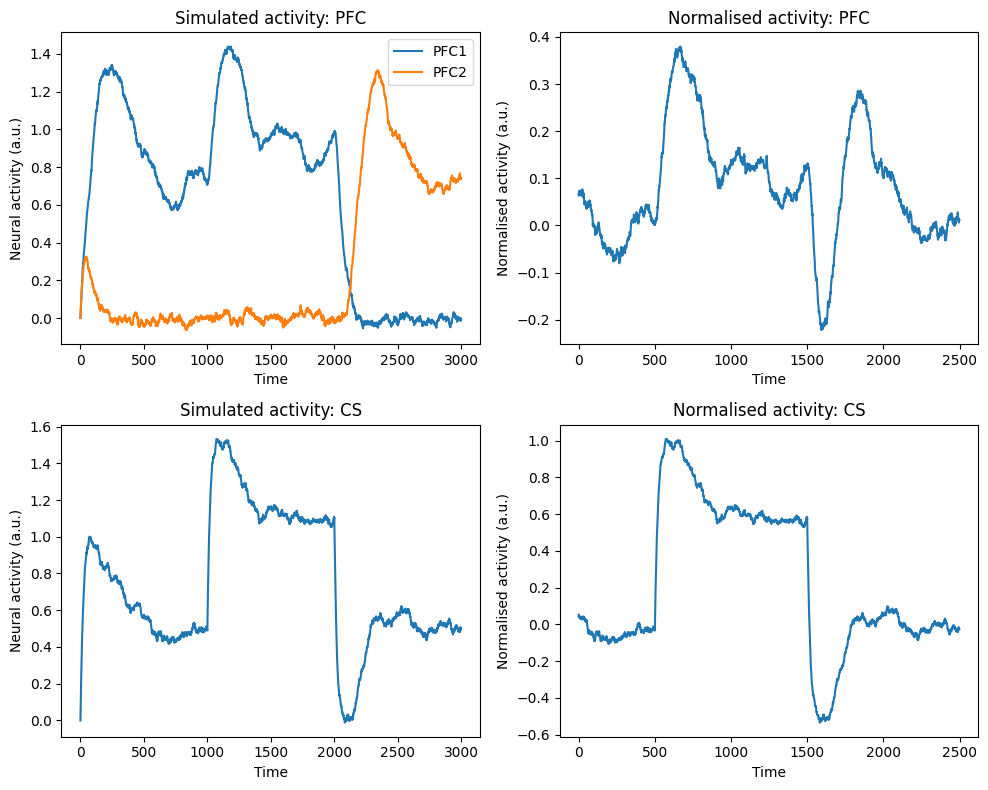

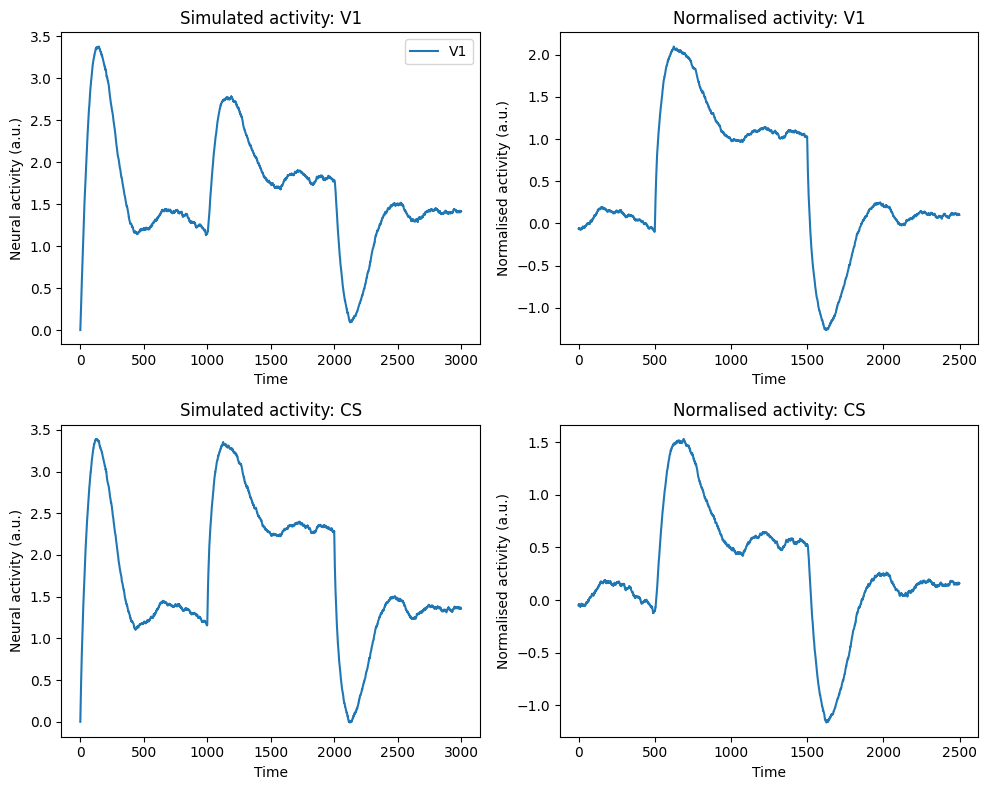

In [24]:
# figures 
example_trl = 5
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Subplot 1: Activity
axs[0, 0].plot(X_GNWT[1:,:,example_trl].T)
axs[0, 0].set_title('Simulated activity: PFC')
axs[0, 0].legend(['PFC1', 'PFC2'])
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Neural activity (a.u.)')

# Subplot 2: normalised activity
axs[0, 1].plot(PFC[:,example_trl])
axs[0, 1].set_title('Normalised activity: PFC')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Normalised activity (a.u.)')

# Subplot 3: Stim on
axs[1, 0].plot(X_GNWT[0,:,example_trl].T)
axs[1, 0].set_title('Simulated activity: CS')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Neural activity (a.u.)')

# Subplot 4: Stim off
axs[1, 1].plot(CS_GNWT[:,example_trl])
axs[1, 1].set_title('Normalised activity: CS')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Normalised activity (a.u.)')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Subplot 1: Activity
axs[0, 0].plot(X_IIT[1:,:,example_trl].T)
axs[0, 0].set_title('Simulated activity: V1')
axs[0, 0].legend(['V1'])
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Neural activity (a.u.)')

# Subplot 2: normalised activity
axs[0, 1].plot(v1[:,example_trl])
axs[0, 1].set_title('Normalised activity: V1')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Normalised activity (a.u.)')

# Subplot 3: Stim on
axs[1, 0].plot(X_IIT[0,:,example_trl].T)
axs[1, 0].set_title('Simulated activity: CS')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Neural activity (a.u.)')

# Subplot 4: Stim off
axs[1, 1].plot(CS_IIT[:,example_trl])
axs[1, 1].set_title('Normalised activity: CS')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Normalised activity (a.u.)')

plt.tight_layout()
plt.show()


In [25]:
# grab the stim on and off time series and add measurment noise

measurment_noise = 1

if not os.path.isfile(f'GNWT_stim_on_{N_sims}_sims.npy'):

    #### IIT model
    v1_stim_on = v1[stim_onset:stim_offset] + np.random.randn(len(v1[stim_onset:stim_offset]),N_sims)*measurment_noise
    CS_IIT_stim_on = CS_IIT[stim_onset:stim_offset] + np.random.randn(len(CS_IIT[stim_onset:stim_offset]),N_sims)*measurment_noise
    v1_stim_off = v1[stim_offset:] + np.random.randn(len(v1[stim_offset:]),N_sims)*measurment_noise
    CS_IIT_stim_off = CS_IIT[stim_offset:] + np.random.randn(len(CS_IIT[stim_offset:]),N_sims)*measurment_noise

    # Combine into 2D array 
    time_series_IIT_stim_on = np.array([CS_IIT_stim_on, v1_stim_on])
    time_series_IIT_stim_off = np.array([CS_IIT_stim_off, v1_stim_off])

    #### GNWT model
    PFC_stim_on = PFC[stim_onset:stim_offset] + np.random.randn(len(PFC[stim_onset:stim_offset]),N_sims)*measurment_noise
    CS_GNWT_stim_on = CS_GNWT[stim_onset:stim_offset] + np.random.randn(len(CS_GNWT[stim_onset:stim_offset]),N_sims)*measurment_noise
    PFC_stim_off = PFC[stim_offset:] + np.random.randn(len(PFC[stim_offset:]),N_sims)*measurment_noise
    CS_GNWT_stim_off = CS_GNWT[stim_offset:] + np.random.randn(len(CS_GNWT[stim_offset:]),N_sims)*measurment_noise

    # Combine into a 2D array 
    time_series_GNWT_stim_on = np.array([CS_GNWT_stim_on, PFC_stim_on])
    time_series_GNWT_stim_off = np.array([CS_GNWT_stim_off, PFC_stim_off])

    # Save to .npy files
    np.save(f'GNWT_stim_on_{N_sims}_sims.npy', time_series_GNWT_stim_on)
    np.save(f'GNWT_stim_off_{N_sims}_sims.npy', time_series_GNWT_stim_off)
    np.save(f'IIT_stim_on_{N_sims}_sims.npy', time_series_IIT_stim_on)
    np.save(f'IIT_stim_off_{N_sims}_sims.npy', time_series_IIT_stim_off)

else:
    time_series_GNWT_stim_on = np.load(f'GNWT_stim_on_{N_sims}_sims.npy')
    time_series_GNWT_stim_off = np.load(f'GNWT_stim_off_{N_sims}_sims.npy')
    time_series_IIT_stim_on = np.load(f'IIT_stim_on_{N_sims}_sims.npy')
    time_series_IIT_stim_off = np.load(f'IIT_stim_off_{N_sims}_sims.npy')


(array([28., 32., 59., 71., 53., 37., 32., 24., 32., 27., 30., 34., 36.,
        27., 28., 32., 28., 25., 33., 26., 28., 25., 28., 22., 22., 22.,
        19., 21., 28., 29., 27., 35.]),
 array([  0.    ,  31.1875,  62.375 ,  93.5625, 124.75  , 155.9375,
        187.125 , 218.3125, 249.5   , 280.6875, 311.875 , 343.0625,
        374.25  , 405.4375, 436.625 , 467.8125, 499.    , 530.1875,
        561.375 , 592.5625, 623.75  , 654.9375, 686.125 , 717.3125,
        748.5   , 779.6875, 810.875 , 842.0625, 873.25  , 904.4375,
        935.625 , 966.8125, 998.    ]),
 <BarContainer object of 32 artists>)

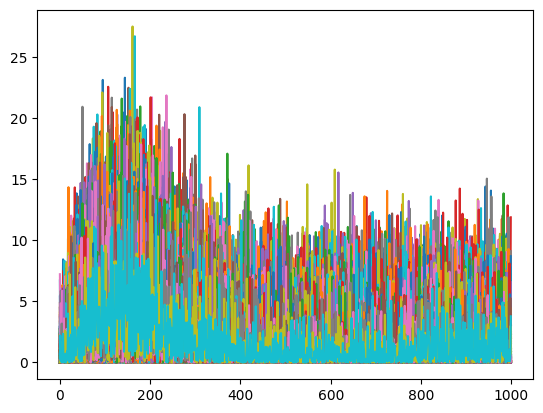

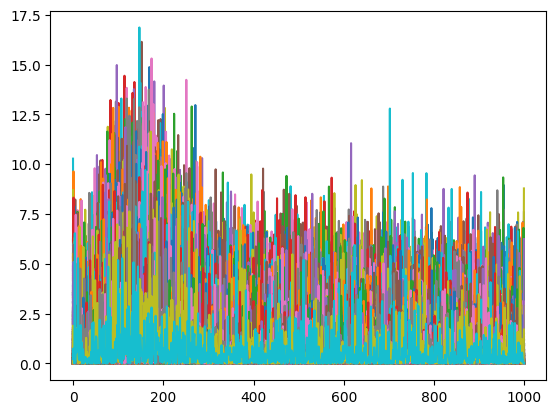

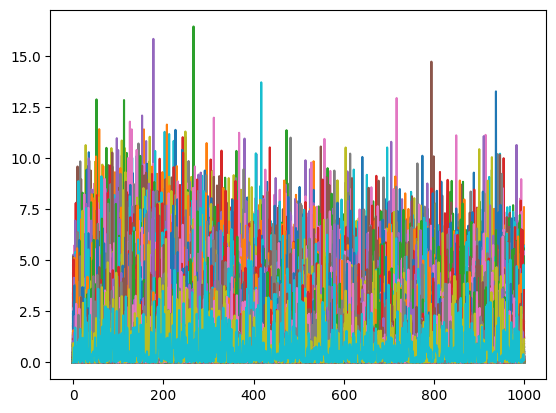

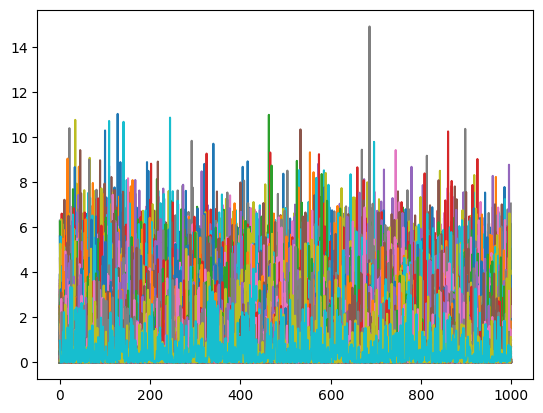

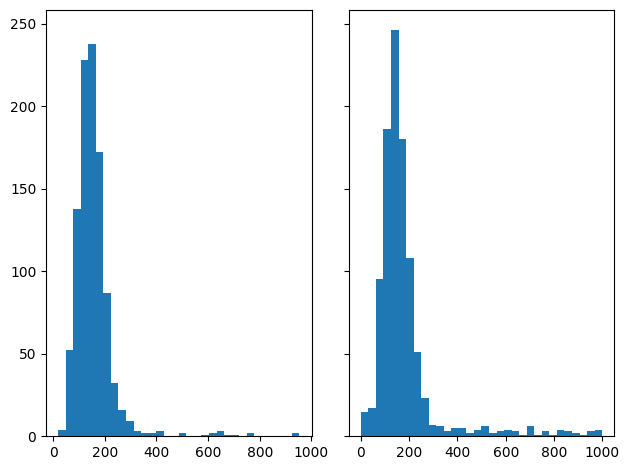

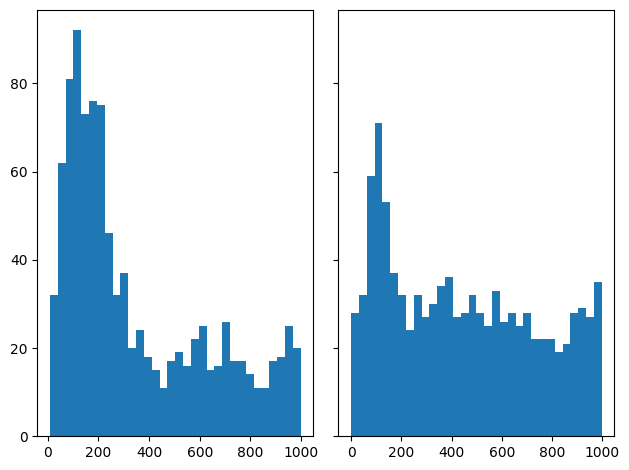

In [43]:
# analysis of simulated time series
#### IIT

# Compute the Euclidean barycenter
barycenter_IIT_stim_on = euclidean_barycenter(time_series_IIT_stim_on)**2
barycenter_IIT_stim_off = euclidean_barycenter(time_series_IIT_stim_off)**2

# Compute the timepoint of max barycenter
max_barycenter_IIT_stim_on = np.argmax(barycenter_IIT_stim_on, axis=0)
max_barycenter_IIT_stim_off = np.argmax(barycenter_IIT_stim_off, axis=0)

# Compute the value of the max barycenter
max_barycenter_val_IIT_stim_on = np.max(barycenter_IIT_stim_on, axis=0)
max_barycenter_val_IIT_stim_off = np.max(barycenter_IIT_stim_off, axis=0)

#### GNWT

# Compute the Euclidean barycenter
barycenter_GNWT_stim_on = euclidean_barycenter(time_series_GNWT_stim_on)**2
barycenter_GNWT_stim_off = euclidean_barycenter(time_series_GNWT_stim_off)**2

# Compute the timepoint of max barycenter
max_barycenter_GNWT_stim_on = np.argmax(barycenter_GNWT_stim_on, axis=0)
max_barycenter_GNWT_stim_off = np.argmax(barycenter_GNWT_stim_off, axis=0)

# Compute the value of the max barycenter
max_barycenter_val_GNWT_stim_on = np.max(barycenter_GNWT_stim_on, axis=0)
max_barycenter_val_GNWT_stim_off = np.max(barycenter_GNWT_stim_off, axis=0)

# Figures of barycenter time series
time = np.linspace(1, 3000, 3000)

plt.figure(5)
plt.plot(barycenter_IIT_stim_on)

plt.figure(6)
plt.plot(barycenter_IIT_stim_off)

plt.figure(7)
plt.plot(barycenter_GNWT_stim_on)

plt.figure(8)
plt.plot(barycenter_GNWT_stim_off)

# histograms of max
n_bins = round(np.sqrt(N_sims))
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(max_barycenter_IIT_stim_on, bins=n_bins)
axs[1].hist(max_barycenter_IIT_stim_off, bins=n_bins)

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(max_barycenter_GNWT_stim_on, bins=n_bins)
axs[1].hist(max_barycenter_GNWT_stim_off, bins=n_bins)


## Plot the distribution of maximum barycenters

In [54]:
max_barycenter_df = pd.DataFrame({
    'Max_Time': np.concatenate((max_barycenter_IIT_stim_on, max_barycenter_IIT_stim_off, 
                                max_barycenter_GNWT_stim_on, max_barycenter_GNWT_stim_off)),
    'Model': np.concatenate((np.repeat('IIT', N_sims*2), np.repeat('GNWT', N_sims*2))),  # ✅ Fix
    'Stim': np.concatenate((np.repeat('On', N_sims), np.repeat('Off', N_sims), 
                            np.repeat('On', N_sims), np.repeat('Off', N_sims))),  # ✅ Fix
    'Max_Value': np.concatenate((max_barycenter_val_IIT_stim_on, max_barycenter_val_IIT_stim_off, 
                                 max_barycenter_val_GNWT_stim_on, max_barycenter_val_GNWT_stim_off))
})
max_barycenter_df.head()

,Max_Time,Model,Stim,Max_Value
0,254,IIT,On,14.396419
1,117,IIT,On,14.622919
2,97,IIT,On,16.168558
3,220,IIT,On,13.004901
4,111,IIT,On,15.348186


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


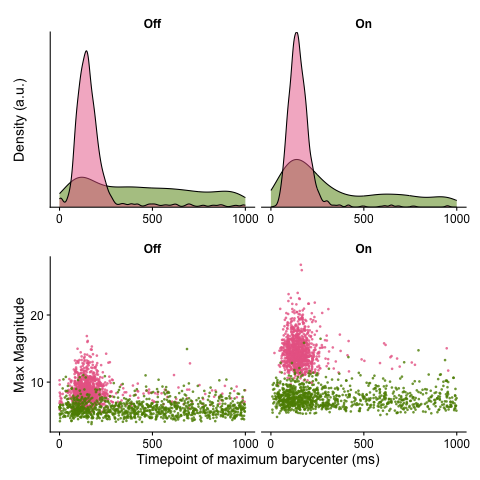

In [60]:
%%R -i max_barycenter_df

bary_max_density_plot <- max_barycenter_df %>% 
    ggplot(data=., mapping=aes(x=Max_Time, fill=Model)) +
    scale_fill_manual(values=c("IIT" = "#e96893", "GNWT" = "#5b8c00"))  +
    scale_x_continuous(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    geom_density(alpha=0.5) +
    facet_grid(. ~ Stim, scales="free") +
    ylab("Density (a.u.)") +
    xlab("Timepoint of maximum barycenter (ms)") +
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

bary_max_scatter_plot <- max_barycenter_df %>% 
    ggplot(data=., mapping=aes(x=Max_Time, y=Max_Value, color=Model)) +
    geom_point(stroke=0, alpha=0.8, size=1.25) +
    facet_grid(. ~ Stim, scales="free")  +
    scale_color_manual(values=c("IIT" = "#e96893", "GNWT" = "#5b8c00"))  +
    ylab("Max Magnitude") +
    xlab("Timepoint of maximum barycenter (ms)")  +
    theme(legend.position="none",
          strip.background = element_blank(),
            strip.text.x = element_text(face='bold'),
            strip.text.y = element_text(angle=0, face='bold'))

wrap_plots(list(bary_max_density_plot, bary_max_scatter_plot), ncol=1) +
      plot_layout(axis_titles = "collect", guides = "collect") &
      scale_x_continuous(breaks=c(0, 500, 1000), limits=c(0, 1000))

In [65]:
%%R 

gg_color_hue <- function(n) {
    hues = seq(15, 375, length = n + 1)
    hcl(h = hues, l = 65, c = 100)[1:n]
    }

# Convert to RGB
hex_colors <- gg_color_hue(11)
rgb_colors <- col2rgb(hex_colors) / 255
rgb_colors

           [,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]
red   0.9725490 0.8588235 0.6823529 0.3921569 0.0000000 0.0000000 0.0000000
green 0.4627451 0.5568627 0.6352941 0.6980392 0.7411765 0.7568627 0.7294118
blue  0.4274510 0.0000000 0.0000000 0.0000000 0.3607843 0.6549020 0.8705882
           [,8]      [,9]     [,10]     [,11]
red   0.0000000 0.7019608 0.9372549 1.0000000
green 0.6509804 0.5215686 0.4039216 0.3882353
blue  1.0000000 1.0000000 0.9215686 0.7137255
